In [5]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
# Load data
df = pd.read_csv("data.csv")
df.columns

Index(['utcDate', 'home_team', 'away_team', 'home_score', 'away_score',
       'Season', 'winner'],
      dtype='object')

In [7]:
# Preprocess data
home_stats = df.groupby("home_team")[["home_score"]].mean().rename(columns={"home_score": "home_team_avg_goals"})
away_stats = df.groupby("away_team")[["away_score"]].mean().rename(columns={"away_score": "away_team_avg_goals"})

df = df.merge(home_stats, on="home_team", how="left")
df = df.merge(away_stats, on="away_team", how="left")

# Add goal difference feature
df["goal_diff_avg"] = df["home_team_avg_goals"] - df["away_team_avg_goals"]

top_teams = ["Manchester City", "Liverpool", "Arsenal", "Chelsea", "Manchester United"]
df["home_is_top"] = df["home_team"].isin(top_teams).astype(int)
df["away_is_top"] = df["away_team"].isin(top_teams).astype(int)

# Add recent form (last 5 matches) for home and away teams
def compute_team_form(df, team_col, score_col, opponent_score_col, new_col):
    forms = {}
    results = []
    for _, row in df.iterrows():
        team = row[team_col]
        if team not in forms:
            forms[team] = []
        # Win = 3 points, Draw = 1 point, Loss = 0 points
        if row[score_col] > row[opponent_score_col]:
            forms[team].append(3)
        elif row[score_col] == row[opponent_score_col]:
            forms[team].append(1)
        else:
            forms[team].append(0)
        # Average of last 5 matches
        results.append(sum(forms[team][-5:]) / len(forms[team][-5:]))
    df[new_col] = results
    return df

df = df.sort_values("utcDate")
df = compute_team_form(df, "home_team", "home_score", "away_score", "home_form")
df = compute_team_form(df, "away_team", "away_score", "home_score", "away_form")

# Add average points per game for home and away teams
team_points = (
    df.groupby("home_team")[["home_score", "away_score"]]
    .apply(lambda x: ((x["home_score"] > x["away_score"]) * 3 + (x["home_score"] == x["away_score"]) * 1).mean())
    .rename("home_points_avg")
)
df = df.merge(team_points, left_on="home_team", right_index=True, how="left")
df = df.merge(team_points, left_on="away_team", right_index=True, how="left", suffixes=("", "_away"))
df["points_diff"] = df["home_points_avg"] - df["home_points_avg_away"]

# Prepare features and target
le_team = LabelEncoder()
df["home_team_enc"] = le_team.fit_transform(df["home_team"])
df["away_team_enc"] = le_team.fit_transform(df["away_team"])

features = [
    "home_team_enc",
    "away_team_enc",
    "home_team_avg_goals",
    "away_team_avg_goals",
    "goal_diff_avg",
    "home_is_top",
    "away_is_top",
    "home_form",
    "away_form",
    "points_diff"
]
target = "winner"

# Split data
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
# Training
model = CatBoostClassifier(
    iterations=1000,
    depth=8,
    learning_rate=0.03,
    loss_function='MultiClass',
    random_seed=42,
    verbose=False
)
cat_features = ["home_team_enc", "away_team_enc"]
model.fit(X_train, y_train, cat_features=cat_features)

In [9]:
# Predictions and Evaluation
y_pred = model.predict(X_test).flatten()

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Accuracy: {acc:.3f}")
print(f"F1-score: {f1:.3f}")

Accuracy: 0.656
F1-score: 0.637


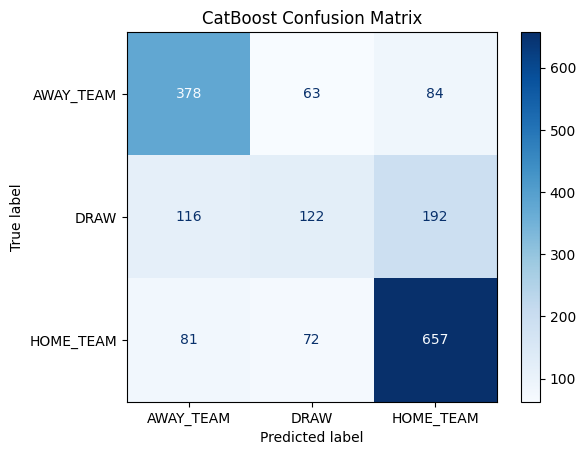

In [10]:
# Error matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title("CatBoost Confusion Matrix")
plt.show()

In [11]:
# Feature Importances
feat_imp = model.get_feature_importance(prettified=True)
print("\n Feature Importances:")
print(feat_imp)


 Feature Importances:
            Feature Id  Importances
0            home_form    27.664309
1            away_form    23.867543
2        home_team_enc    16.695035
3        away_team_enc    15.884099
4          points_diff     4.288749
5        goal_diff_avg     3.964941
6  away_team_avg_goals     3.382510
7  home_team_avg_goals     3.307906
8          home_is_top     0.525993
9          away_is_top     0.418915


In [ ]:
import pickle

with open("models/model.pkl", "wb") as f:
    pickle.dump({"model": model, "encoder": le_team}, f)

print("model.pkl saved")

In [ ]:
df.to_csv("data/features.csv", index=False)